# Load Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import io
from PIL import Image
from PIL import ImageDraw
from tqdm import tqdm
import os, json, math
from lifelines import KaplanMeierFitter
from typing import List, Dict, Tuple, Optional, Union, Any, Iterable

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.backends.backend_pdf import FigureCanvasPdf
from reportlab.lib.pagesizes import letter
from reportlab.lib import colors
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer
from reportlab.lib.styles import getSampleStyleSheet

# Generate Synthetic Data

In [2]:
def simulate_true_ipd(n: int,
                      dist: str = "weibull",
                      shape: float = 1.5,   # Weibull k
                      scale: float = 8.0,   # Weibull lambda
                      c_max: float = 12.0,
                      random_state: int = 0) -> pd.DataFrame:
    """
    Simulate ground truth:
    Event times T: from a distribution (Weibull/Exponential)
    Censor time: independent Uniform (0, c_max)
    More/less censoring: change c_max
    Increasing/decreasing hazards: change shape (Weibull k)
    Heavier tails/faster failures: change scale
    
    """
    rng = np.random.default_rng(random_state)
    if dist.lower() == "weibull":
        T = scale * rng.weibull(shape, size=n)
    elif dist.lower() == "exponential":
        T = rng.exponential(scale=scale, size=n)
    else:
        raise ValueError("dist must be 'weibull' or 'exponential'") # more distirbution types?
    C = rng.uniform(0.0, c_max, size=n) # indepdenent censoring - adjust
    X = np.minimum(T, C) # observed time
    E = (T <= C).astype(int) # event indicator
    return pd.DataFrame({"time": X, "event": E})

def km_drop_points(times: np.ndarray, events: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """
    Converts the perfect subject-level data (IPD) into the coordinates of the perfect, ideal Kaplan-Meier curve.
    Fit a KM fitter to the IPD
    Return (t,S) at bottoms of KM drops (event times; survival after the drop). This represents the curve for digitzation
    
    """
    kmf = KaplanMeierFitter().fit(times, event_observed=events)
    et = kmf.event_table.reset_index()
    drop_rows = et[et["observed"] > 0].copy()
    S_series = kmf.survival_function_.reindex(drop_rows["event_at"]).iloc[:, 0]
    t = drop_rows["event_at"].to_numpy(dtype=float)
    S = S_series.to_numpy(dtype=float)
    mask = t > 0  # drop any t=0
    return t[mask], S[mask]

def simulate_digitization_from_km(true_ipd: pd.DataFrame,
                                  keep_frac: float = 0.85,
                                  sigma_t: float = 0.08,
                                  sigma_S: float = 0.008,
                                  round_t: Optional[int] = 2,
                                  round_S: Optional[int] = 3,
                                  tick_capture_rate: float = 0.6,
                                  sigma_tick: float = 0.05,
                                  random_state: int = 1) -> Dict[str, Any]:
    """
    Create (t_dig, S_dig, cens_dig) from a true KM with thinning/jitter/rounding.
    """
    rng = np.random.default_rng(random_state)

    # Get true KM drop points
    t_true, S_true = km_drop_points(true_ipd["time"].to_numpy(),
                                    true_ipd["event"].to_numpy())
    m = t_true.size
    if m == 0:
        return {"t_dig": np.array([]), "S_dig": np.array([]), "cens_dig": np.array([]),
                "t_true": t_true, "S_true": S_true}

    # thinning
    keep = rng.uniform(size=m) < keep_frac
    if keep.sum() == 0:
        keep[rng.integers(0, m)] = True
    t_keep, S_keep = t_true[keep].copy(), S_true[keep].copy()

    # jitter
    if sigma_t > 0:
        t_keep = np.clip(t_keep + rng.normal(0, sigma_t, size=t_keep.size), 0, None)
    if sigma_S > 0:
        S_keep = S_keep + rng.normal(0, sigma_S, size=S_keep.size)

    # rounding of the (bottom) KM drops
    if round_t is not None:
        t_keep = np.round(t_keep, round_t)
    if round_S is not None:
        S_keep = np.round(S_keep, round_S)

    # build paired points (top & bottom) at each drop time
    if S_keep.size:
        S_before = np.r_[1.0, S_keep[:-1]]
        t_pair = np.repeat(t_keep, 2)
        S_pair = np.empty(t_pair.size)
        S_pair[0::2] = S_before
        S_pair[1::2] = S_keep

        if sigma_t and round_t is not None:
            eps = 10 ** (-(round_t + 2))
            t_pair[0::2] = np.maximum(0.0, t_pair[0::2] - eps)

        if round_t is not None:
            t_pair = np.round(t_pair, round_t)
        if round_S is not None:
            S_pair = np.round(S_pair, round_S)

        dfp = (
            pd.DataFrame({"t": t_pair, "S": S_pair})
            .groupby("t", as_index=False)["S"]
            .agg(lambda s: [s.max(), s.min()])
            .explode("S", ignore_index=True)
            .astype({"S": float})
            .sort_values(["t", "S"], ascending=[True, False])
        )

        t_keep = dfp["t"].to_numpy(float)
        S_keep = dfp["S"].to_numpy(float)

        t_keep = np.concatenate(([0.0], t_keep))
        S_keep = np.concatenate(([1.0], S_keep))

        t_keep = np.concatenate((t_keep,[np.max(true_ipd['time'])]))
        S_keep = np.concatenate((S_keep, [S_keep[-1]]))

    # censor ticks
    cens_times = true_ipd.loc[true_ipd["event"] == 0, "time"].to_numpy()
    if cens_times.size > 0:
        mask = rng.uniform(size=cens_times.size) < tick_capture_rate
        cens_dig = cens_times[mask]
        if cens_dig.size > 0 and sigma_tick > 0:
            cens_dig = np.clip(cens_dig + rng.normal(0, sigma_tick, size=cens_dig.size), 0, None)
        cens_dig = np.sort(cens_dig)
    else:
        cens_dig = np.array([])

    
    return {
        "t_dig": t_keep,
        "S_dig": S_keep,
        "cens_dig": cens_dig,
        "t_true": t_true,
        "S_true": S_true,
    }

def generate_risk_table(df: pd.DataFrame, n_interval: int) -> pd.DataFrame:
    """
    Generate a risk table showing number at risk at regular time intervals.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns 'time' and 'event' (1=event, 0=censor)
    n_interval : int
        Number of intervals between 0 and ceil(max(time))

    Returns
    -------
    pd.DataFrame
        Columns: ['time', 'n_at_risk'], both integers
    """
    # Sort by time
    df = df.sort_values('time').reset_index(drop=True)

    # Define interval cut points
    max_time = np.ceil(df['time'].max())
    interval = np.ceil(max_time / n_interval).astype(int)
    time_points = np.arange(0, (n_interval + 1) * interval, interval)

    # Compute number at risk at each interval start
    n_total = len(df)
    n_at_risk = []

    for t in time_points:
        n_alive = np.sum(df['time'] >= t)
        n_at_risk.append(int(n_alive))

    risk_table = pd.DataFrame({
        'time': time_points,
        'n_at_risk': n_at_risk
    })

    return risk_table

## Simulate IPD

In [13]:
n = 100
n_rep_censor = 20
n_rep_event = 20
c_max = 30
seed = 2
true_ipd = simulate_true_ipd(n, dist="weibull", shape=1.4, scale=10.0, c_max=c_max, random_state=seed)

# Insert duplicated censor points to ensure they are at the end of the same time as events
censored_ipd = true_ipd[true_ipd['event'] == 0].reset_index(drop=True).copy().sort_values('time').reset_index(drop=True)
replicated_censors = censored_ipd.sample(n=n_rep_censor, replace=True, random_state=seed)
true_ipd = pd.concat([true_ipd, replicated_censors], ignore_index=True).sort_values('time').reset_index(drop=True)

# Insert duplicated event points to ensure they are at the end of the same time as events
event_ipd = true_ipd[true_ipd['event'] == 1].reset_index(drop=True).copy().sort_values('time').reset_index(drop=True)
replicated_event = event_ipd.sample(n=n_rep_event, replace=True, random_state=seed)
true_ipd = pd.concat([true_ipd, replicated_event], ignore_index=True).sort_values('time').reset_index(drop=True)

# Generate Risk Table
risk_df = generate_risk_table(true_ipd, n_interval=8)

# Simulate Digitization
keep_frac = 1  # Fraction of points to keep
sigma_t = 0  # Noise in time
sigma_S = 0  # Noise in survival probability
round_t = 8  # Rounding for time
round_S = 8  # Rounding for survival probability
tick_capture_rate = 1  # Capture rate for censor ticks
sigma_tick = 0  # Noise in censor ticks

dig = simulate_digitization_from_km(
    true_ipd=true_ipd,
    keep_frac=keep_frac,
    sigma_t=sigma_t,
    sigma_S=sigma_S,
    round_t=round_t,
    round_S=round_S,
    tick_capture_rate=tick_capture_rate,
    sigma_tick=sigma_tick,
    random_state=seed
)

dat = pd.DataFrame({"time": np.asarray(dig["t_dig"], float),
                    "sur":  np.asarray(dig["S_dig"], float)}).sort_values("time").reset_index(drop=True)

def extract_km_drops_from_dig(dig):
    t = np.asarray(dig["t_dig"], float)
    S = np.asarray(dig["S_dig"], float)
    o = np.argsort(t); t, S = t[o], S[o]
    S = np.minimum.accumulate(S)                 
    drop_idx = np.where(np.r_[False, S[1:] < S[:-1]])[0]
    return np.clip(t[drop_idx], 0.0, None), np.clip(S[drop_idx], 0.0, 1.0)

t_drop, S_drop = extract_km_drops_from_dig(dig)

cens_t = np.asarray(dig.get("cens_dig", []), float) if "cens_dig" in dig else None
cens_t = np.unique(cens_t)

# CEN-KM Reconstruction

In [14]:
from CEN_KM import get_ipd
recon_ipd = get_ipd(n=true_ipd.shape[0], t=t_drop, S=S_drop, cens_t=cens_t, match_tol=1e-6, max_extra_censors_per_bin=10, random_state=seed)

# Visualization

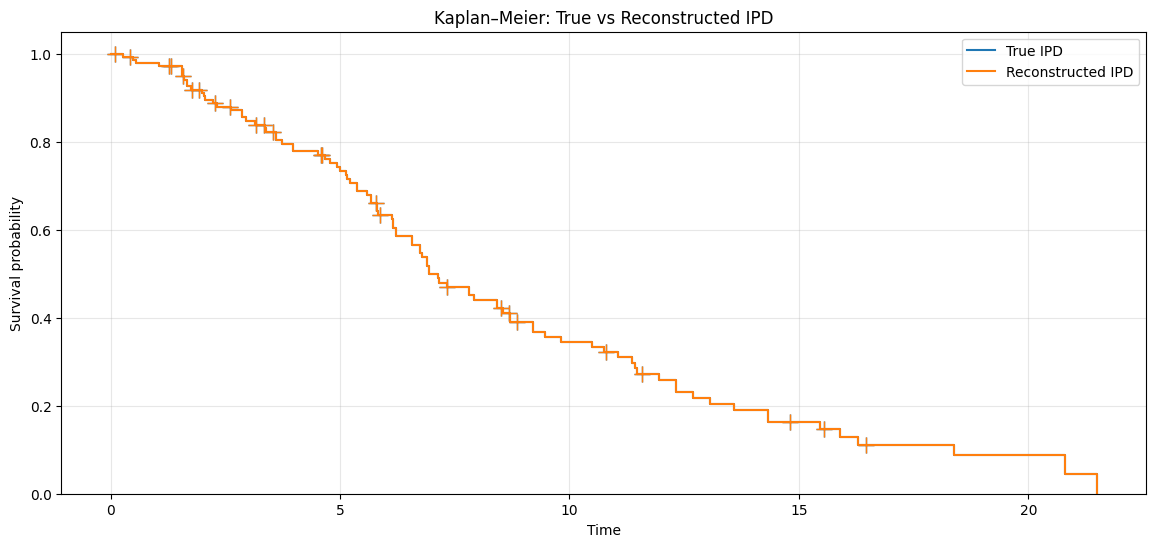

In [15]:
# Overlay KM curves for true and reconstructed IPD
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, ax = plt.subplots(figsize=(14, 6))

km_true = KaplanMeierFitter(label="True IPD")
km_recon = KaplanMeierFitter(label="Reconstructed IPD")

# Fit KM on true and reconstructed IPD
km_true.fit(true_ipd["time"].to_numpy(), event_observed=true_ipd["event"].to_numpy())
km_recon.fit(recon_ipd["time"].to_numpy(), event_observed=recon_ipd["event"].to_numpy())

# Plot survival functions
km_true.plot_survival_function(ax=ax, ci_show=False, color="tab:blue", show_censors=True)
km_recon.plot_survival_function(ax=ax, ci_show=False, color="tab:orange", show_censors=True)

ax.set_title("Kaplan–Meier: True vs Reconstructed IPD")
ax.set_xlabel("Time")
ax.set_ylabel("Survival probability")
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3)
ax.legend(loc="best")

plt.show()